# **Importing Necessary Libraries**

In [1]:
import cv2
import shutil
import random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-04-19 14:50:45.719997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 14:50:45.720056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 14:50:45.721769: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Some Configuration

In [2]:
df = pd.read_csv("../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv")

diagnosis_binary = {
        0: 'No_DR',
        1: 'DR',
        2: 'DR',
        3: 'DR',
        4: 'DR'}

diagnosis_classes = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df["binary"] = df["diagnosis"].map(diagnosis_binary.get)
df["type"] = df["diagnosis"].map(diagnosis_classes.get)

In [ ]:
plt.figure(figsize = (8,8))

# **Data Visualization**

In [ ]:
df.head()

In [ ]:
plt.figure(figsize = (8,5))
df['type'].value_counts().plot(kind='barh')

In [ ]:
df['binary'].value_counts().plot(kind='barh')

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
for column in df.columns:
    if column == "id_code":
        pass
    else:
        print(df[column].value_counts())

# **Data Preprocessing**

In [ ]:
!pip install imutils

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from imutils import paths
from sklearn.utils import shuffle

In [ ]:
data = []
labels = []
width,height=224,224

imagePaths = list(paths.list_images('../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'))

data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]   
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data, labels = shuffle(data, labels)

print(data.shape)
print(labels.shape)

In [ ]:
from imblearn.over_sampling import SMOTE

# Reshape the data into 2D format
data = data.reshape(data.shape[0], -1)

# Apply SMOTE to balance the classes
smote = SMOTE()
data_resampled, labels_resampled = smote.fit_resample(data, labels)

# Reshape the data back to its original shape
data_resampled = data_resampled.reshape(data_resampled.shape[0], width, height, 3)

# Shuffle the data
data_resampled, labels_resampled = shuffle(data_resampled, labels_resampled)

print(data_resampled.shape)
print(labels_resampled.shape)

In [ ]:
# Normalization 
data_resampled = data_resampled / 255.0

# **Splitting Data to Training , Validatoin and Testing Sets**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_resampled, labels_resampled, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

In [ ]:
np.save('X_train.npy', x_train)
np.save('X_test.npy', x_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [3]:
x_train = np.load('/kaggle/working/X_train.npy')
x_test = np.load('/kaggle/working/X_test.npy')
y_train = np.load('/kaggle/working/y_train.npy')
y_test = np.load('/kaggle/working/y_test.npy')

# Building the model

In [4]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from keras.models import Model

# **Fine-Tuning VGG16**

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(input_shape=(224,224,3),weights='imagenet',include_top=False)

for layer in vgg.layers:
    layer.trainable = False

In [6]:
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout,Activation,BatchNormalization,Lambda

x = Flatten()(vgg.output)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
prediction = Dense(5,activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [7]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

#Early Stopping

es = EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience=5, verbose=1, mode='auto')

#Model Check Point

mc = ModelCheckpoint(monitor='val_accuracy', filepath = '/kaggle/working/final_version_vgg16.keras', verbose=1, save_best_only = True, mode='auto')

cd = [es,mc]

In [8]:
import tensorflow
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy',
              optimizer = adam,
              metrics=['accuracy']
)

In [9]:
history = model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),
          epochs=40,
          callbacks=cd,
          batch_size = 32,
          shuffle=True)

Epoch 1/40


2024-04-19 14:51:36.617678: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-04-19 14:51:36.617744: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-04-19 14:51:36.617754: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-04-19 14:51:36.617761: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-04-19 14:51:36.617769: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-04-19 14:51:36.617777: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-04-19 14:51:36.617785: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-04-19 14:51:36.617792: E external/local_xla/xla/se

  2/226 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.2500 - loss: 0.7620   

I0000 00:00:1713538312.698395    3088 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3169 - loss: 0.5169

2024-04-19 14:52:09.092289: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.79983, expected 3.15789
2024-04-19 14:52:09.092357: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.13466, expected 4.49272
2024-04-19 14:52:09.092366: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 4.78155, expected 4.13961
2024-04-19 14:52:09.092374: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 4.88295, expected 4.24101
2024-04-19 14:52:09.092382: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.73279, expected 4.09085
2024-04-19 14:52:09.092389: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.69943, expected 4.05749
2024-04-19 14:52:09.092397: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.1975, expected 3.55556
2024-04-19 14:52:09.092404: 

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3172 - loss: 0.5167

2024-04-19 14:52:28.080929: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 5.04893, expected 4.24247
2024-04-19 14:52:28.080991: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.99988, expected 6.19341
2024-04-19 14:52:28.081000: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 6.949, expected 6.14253
2024-04-19 14:52:28.081008: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 6.3455, expected 5.53903
2024-04-19 14:52:28.081016: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100356: 6.4062, expected 5.59973
2024-04-19 14:52:28.081023: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100357: 6.93991, expected 6.13344
2024-04-19 14:52:28.081031: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100358: 5.95738, expected 5.15092
2024-04-19 14:52:28.0810


Epoch 1: val_accuracy improved from -inf to 0.51025, saving model to /kaggle/working/final_version_vgg16.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 62s 188ms/step - accuracy: 0.3175 - loss: 0.5165 - val_accuracy: 0.5102 - val_loss: 0.4018
Epoch 2/40
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4707 - loss: 0.4173
Epoch 2: val_accuracy improved from 0.51025 to 0.51579, saving model to /kaggle/working/final_version_vgg16.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.4707 - loss: 0.4173 - val_accuracy: 0.5158 - val_loss: 0.3835
Epoch 3/40
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4844 - loss: 0.4013
Epoch 3: val_accuracy improved from 0.51579 to 0.52742, saving model to /kaggle/working/final_version_vgg16.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.4844 - loss: 0.4013 - val_accuracy: 0.5274 - val_loss: 0.3715
Epoch 4/40
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5015 - loss: 0.3924
Epoch 4: val_accuracy improved from 0.527

# Plot the Curves

<Figure size 800x800 with 0 Axes>

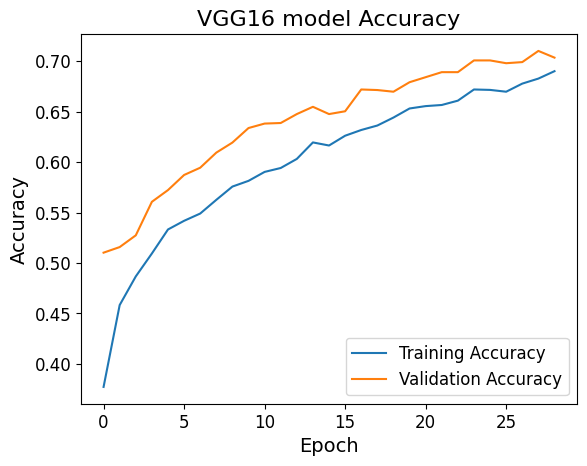

In [10]:
# Plot accuracy curve
plt.figure(figsize=(8,8))
history = history
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], label='Training Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_title('VGG16 model Accuracy', fontsize=16)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(loc='lower right', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
plt.show()

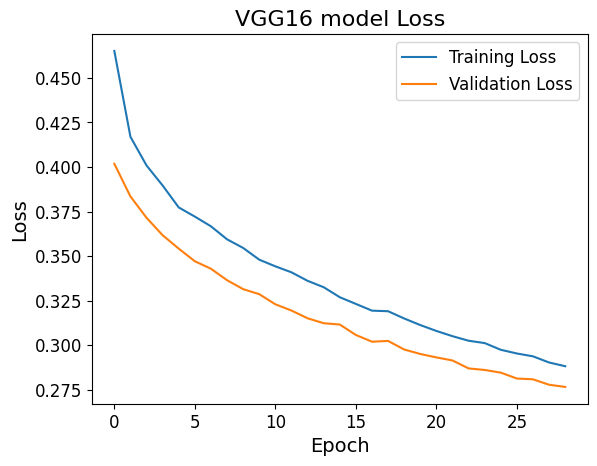

In [11]:
# Plot loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 model Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.show()

# Evaluating the model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/working/final_version.keras")

In [12]:
loss, score = model.evaluate(x_test,y_test)

print("model loss: ", loss)
print("model accuracy: ", score*100)

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7024 - loss: 0.2829
model loss:  0.27646300196647644
model accuracy:  70.36011219024658


In [13]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step


In [14]:
# Step-1 (the Prediction step)

# Predicting the Test set results
HH_Ann_model_y_pred = model.predict(x_test) 

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step


In [15]:
# Some Information about the variable
HH_Ann_model_y_pred[0], type(HH_Ann_model_y_pred), HH_Ann_model_y_pred.ndim

(array([1.0122415e-06, 7.6588043e-07, 9.9999750e-01, 5.7000847e-07,
        9.6694144e-08], dtype=float32),
 numpy.ndarray,
 2)

In [16]:
# Step-2 Converting the Results into a DataFrame shape
HH_pred_df = pd.DataFrame(HH_Ann_model_y_pred)

HH_pred_df.head(), HH_pred_df.shape

(          0             1         2             3             4
 0  0.000001  7.658804e-07  0.999997  5.700085e-07  9.669414e-08
 1  0.053654  1.011296e-01  0.076550  2.681460e-01  5.005212e-01
 2  0.942256  1.877750e-02  0.008590  2.088882e-02  9.487738e-03
 3  0.007223  2.678183e-01  0.003086  1.104192e-01  6.114537e-01
 4  0.000020  9.046922e-01  0.083132  1.115728e-02  9.977922e-04,
 (1805, 5))

In [17]:
# Step-3 Converting the labels of the DataFrame of the Step-2

# Define a function to modify the values in each row
def modify_row(row):
    # Calculate the largest number in the current row
    max_value = row.max()

    # Replace the largest number in the current row with 1 and the rest with 0
    row[row != max_value] = 0
    row[row == max_value] = 1

    # Return the modified row
    return row

# Apply the modify_row function to each row of the DataFrame
HH_labels = HH_pred_df.apply(modify_row, axis=1)

In [18]:
HH_labels.head(), HH_labels.shape

(     0    1    2    3    4
 0  0.0  0.0  1.0  0.0  0.0
 1  0.0  0.0  0.0  0.0  1.0
 2  1.0  0.0  0.0  0.0  0.0
 3  0.0  0.0  0.0  0.0  1.0
 4  0.0  1.0  0.0  0.0  0.0,
 (1805, 5))

In [19]:
# Step-5 converting the predicted labels to numpy array

# The converstion
labels_arr = HH_labels.to_numpy()
labels_arr

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [20]:
# Step-6 collect the DataFrame(actual labels, predictied labels)

# Define the class names
classes = diagnosis_classes

# Convert the arrays to a single column
Y_test_col = y_test.argmax(axis=1)
labels_col = labels_arr.argmax(axis=1)

# Replace the values with their corresponding keys
Y_test_col = pd.Series(Y_test_col).map(classes)
labels_col = pd.Series(labels_col).map(classes)

# Create a new dataframe
df = pd.DataFrame({'True Label': Y_test_col, 'Predicted Label': labels_col})

In [21]:
df.head()

True Label Predicted Label
0        Moderate        Moderate
1  Proliferate_DR  Proliferate_DR
2           No_DR           No_DR
3  Proliferate_DR  Proliferate_DR
4            Mild            Mild

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Step-7 compute the Measurements for the model

# Create the Confusion Matrix out of the Actual and Predicted Data
cm = confusion_matrix(df["True Label"], df["Predicted Label"], labels=list(classes.values()))

# Calculate the accuracy score
accuracy = accuracy_score(df["True Label"], df["Predicted Label"])

# Calculate the precision score
precision = precision_score(df["True Label"], df["Predicted Label"], average='weighted')

# Calculate the recall score
recall = recall_score(df["True Label"], df["Predicted Label"], average='weighted')

# Calculate the F1 score
f1 = f1_score(df["True Label"], df["Predicted Label"], average='weighted')

# Calculate the sensitivity and specificity
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1:, 1:].sum() / (cm[1:, 0] + cm[1:, 1:].sum())

# Calculate the PPV and NPV
ppv = cm[0, 0] / (cm[0, 0] + cm[1:, 0].sum())
npv = cm[1:, 1:].sum() / (cm[0, 1] + cm[1:, 1:].sum())

# Print the evaluation metrics
print('Accuracy Score:', accuracy)
print('Precision Score:', precision)
print('Recall Score:', recall)
print('F1 Score:', f1)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('PPV:', ppv)
print('NPV:', npv)

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(8, 8))

# Generate the heatmap with Seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=list(classes.values()), yticklabels=list(classes.values()), ax=ax, linewidths=0.5, linecolor='gray')

# Set the axis labels and title
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_title('Confusion Matrix for VGG16 model', fontsize=16)

# Set the colorbar properties
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# Set the tick labels' font size
ax.tick_params(axis='both', labelsize=12)

# Display the figure
plt.show()

Accuracy Score: 0.703601108033241
Precision Score: 0.6989296691527762
Recall Score: 0.703601108033241
F1 Score: 0.6955718650673783
Sensitivity: 0.9218241042345277
Specificity: [0.95245283 0.99448385 0.94461078 0.98210117]
PPV: 0.6288888888888889
NPV: 0.9813374805598756


In [23]:
from sklearn.metrics import cohen_kappa_score

# Calculate the kappa score
kappa = cohen_kappa_score(df["True Label"], df["Predicted Label"])

print("Kappa Score for the VGG16 model:", kappa)

Kappa Score for the VGG16 model: 0.6295471511948632


In [24]:
# Generate classification report
from sklearn.metrics import classification_report

report_HH = classification_report(df["True Label"], df["Predicted Label"])

print(report_HH);

                precision    recall  f1-score   support

          Mild       0.65      0.51      0.57       374
      Moderate       0.87      0.96      0.91       358
         No_DR       0.63      0.75      0.69       376
Proliferate_DR       0.70      0.79      0.74       334
        Severe       0.66      0.52      0.58       363

      accuracy                           0.70      1805
     macro avg       0.70      0.71      0.70      1805
  weighted avg       0.70      0.70      0.70      1805



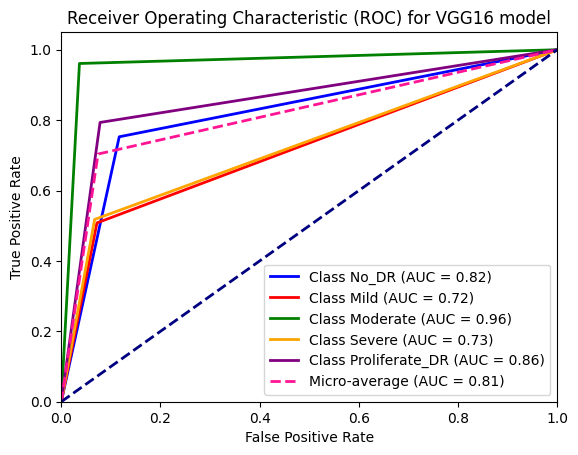

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the true labels and predicted labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_pred_bin = label_binarize(HH_Ann_model_y_pred, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Modify colors as needed
classes = diagnosis_classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(classes[i], roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
         label='Micro-average (AUC = {0:0.2f})'.format(roc_auc["micro"]))


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for VGG16 model')
plt.legend(loc="lower right")
plt.show()

# ***Visualizing a prediction***

In [26]:
index =5
predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"] 

img = x_test[index]
RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
RGBImg= cv2.resize(RGBImg,(224,224))

plt.imshow(RGBImg)
print(y_test[index]) # true
print(f"Prediction: {predictions[pred[index]]}") # predicted  

[0 0 0 1 0]
Prediction: Mild


# **Predicting a new Sample**

In [27]:
import cv2

def predict_new(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    predict=model.predict(np.array([image]))
    pred=np.argmax(predict,axis=1)
    
    print(f"Predicted: {predictions[pred[0]]}")

2024-04-19 15:03:54.412234: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.42855, expected 3.64542
2024-04-19 15:03:54.412302: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.87036, expected 5.08723
2024-04-19 15:03:54.412312: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.04003, expected 5.2569
2024-04-19 15:03:54.412320: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.22034, expected 5.43722
2024-04-19 15:03:54.412328: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.90026, expected 4.11714
2024-04-19 15:03:54.412335: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.21068, expected 4.42756
2024-04-19 15:03:54.412343: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.92061, expected 5.13748
2024-04-19 15:03:54.412350: E external/local_xla/xla/ser

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: Proliferate_DR


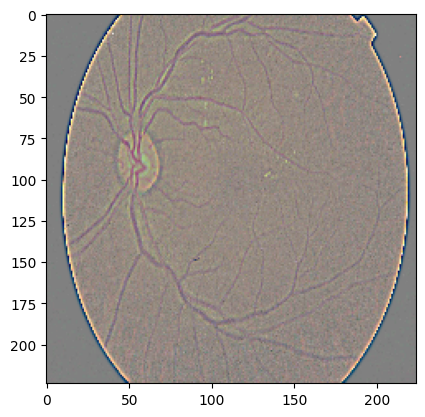

In [28]:
predict_new("../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/01b3aed3ed4c.png")
#True --> Mild